In [1]:
# -- Bib
import os
import sys
sys.path.append("..")

import glob
from pathlib import Path
import networkx as nx
import geopandas as gpd
import pandas as pd
import datetime as dt
import geopandas as gpd
import numpy as np
from shapely.geometry import MultiPolygon, Polygon
from dateutil.relativedelta import relativedelta
import mapclassify
from collections import defaultdict
from scipy.stats import linregress

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

idx = pd.IndexSlice

# -- base paths
basepath = Path.home().joinpath("Documents", "data")
cnespath = basepath.joinpath("opendatasus", "cnes")
geopath = basepath.joinpath("shapefilesceqgis")
simpath = basepath.joinpath("sim", "DBF")
gmlpath = basepath.joinpath("redes_aih")
ccapath = basepath.joinpath("cca_erneson")
figpath = gmlpath.joinpath("doc_final")

# -- load geo
geodata_df = gpd.read_parquet(geopath.joinpath("ce_geodata.parquet"))
ce_geodata_df = gpd.read_parquet(geopath.joinpath("ce_regiao_saude_municipios.parquet"))

setor_df = gpd.read_file(geopath.joinpath("CE_Malha_Preliminar_2022", "CE_Malha_Preliminar_2022.shp"))
setor_df["GEOCOD6"] = setor_df["CD_MUN"].apply(lambda x: x[:6])

In [114]:
ce_border = Polygon(setor_df.geometry.unary_union.exterior)
ce_border = gpd.GeoDataFrame({"FRONTEIRA": [ 'CE' ]}, geometry=[ce_border])

fortal_border = Polygon(setor_df[setor_df["NM_MUN"]=="Fortaleza"].geometry.unary_union.exterior)
fortal_border = gpd.GeoDataFrame({"FRONTEIRA": [ 'Fortaleza' ]}, geometry=[fortal_border])

## **Pop**

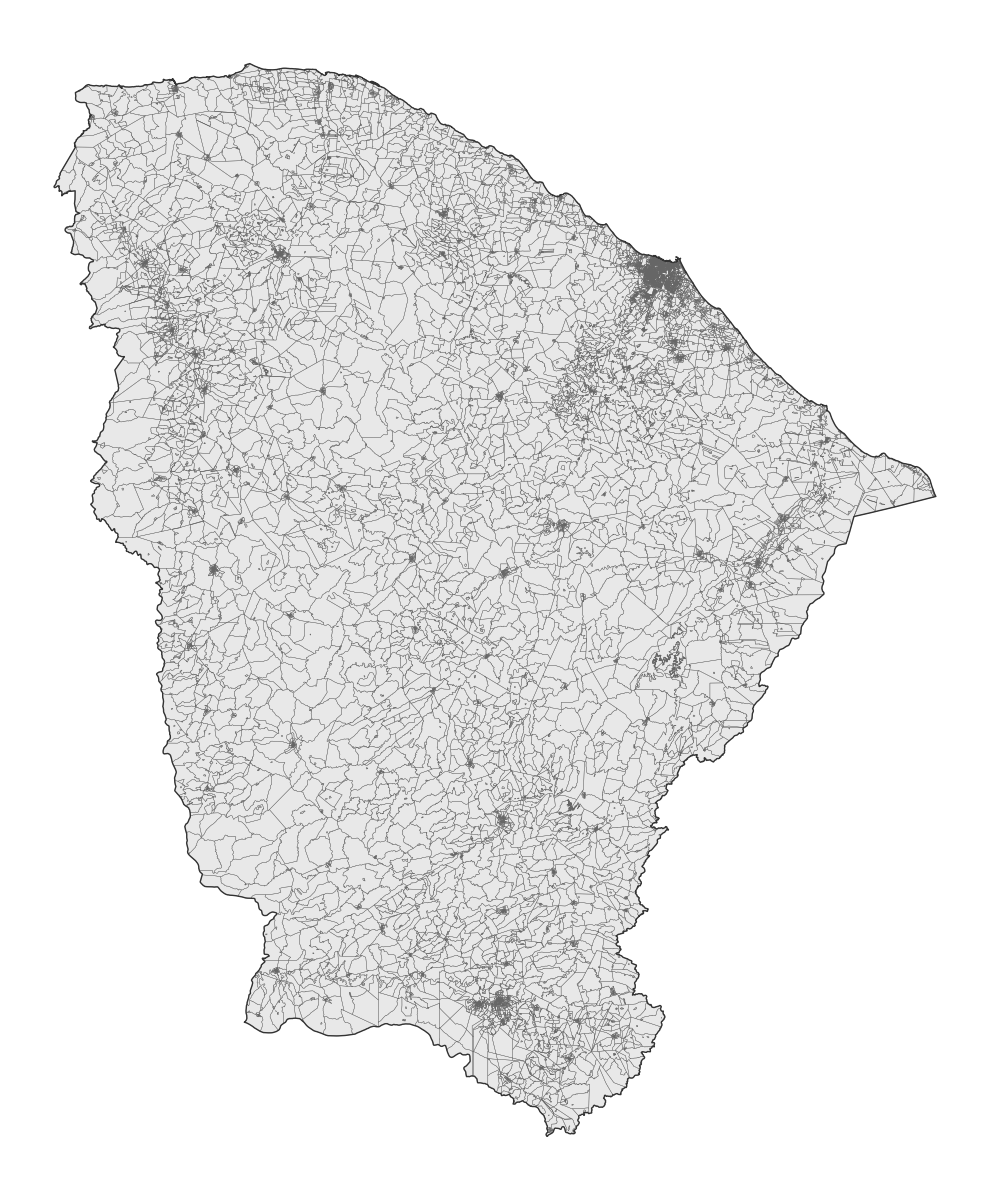

In [48]:
fig, ax = plt.subplots(1,1, figsize=(10,14))

setor_df.plot(ax=ax, color="#b3b3b3", alpha=0.3, edgecolor="#666666", antialiased=True, linewidth=0.0)
setor_df.plot(ax=ax, color="none", edgecolor="#666666", linewidth=0.25)
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)

ax.axis('off')
fig.tight_layout()

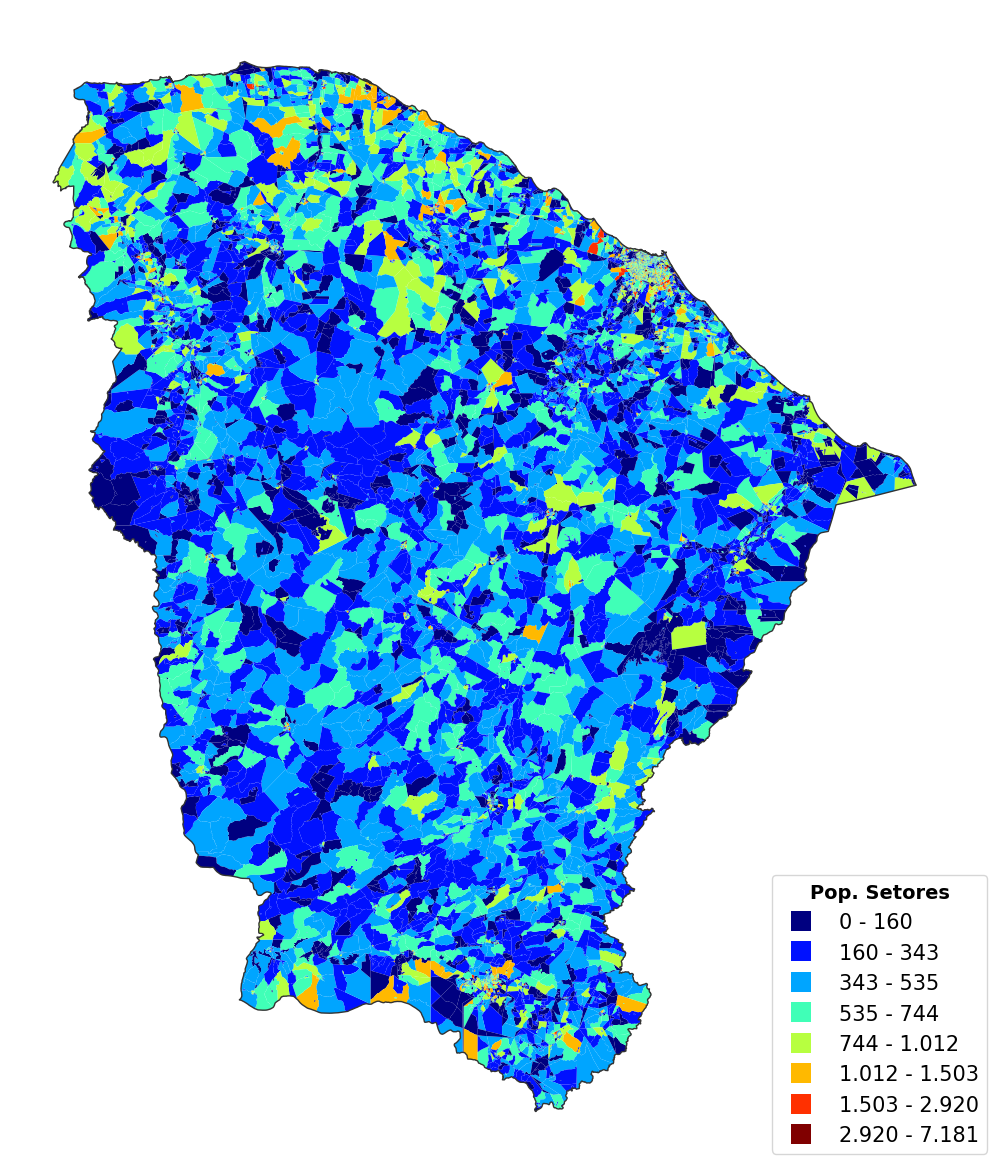

In [21]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.0f} - {label[1]:,.0f}'.replace(",",".")
    else:
        return f'{label[0]:,.0f} - {label[1]:,.0f} ({counts[index]})'.replace(",",".")

fig, ax = plt.subplots(1,1, figsize=(10,14))

setor_df.plot(ax=ax, column='v0001', edgecolor="#4d4d4d", 
              legend=True,
              scheme="NaturalBreaks",
              k=8,
              cmap='jet',
              antialiased=True,
              linewidth=0.0)
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)

for axis in [ax]:
    axis.axis('off')
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(14)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'Pop. Setores', bbox_to_anchor=(1.04,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

ax.axis('off')
fig.tight_layout()

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


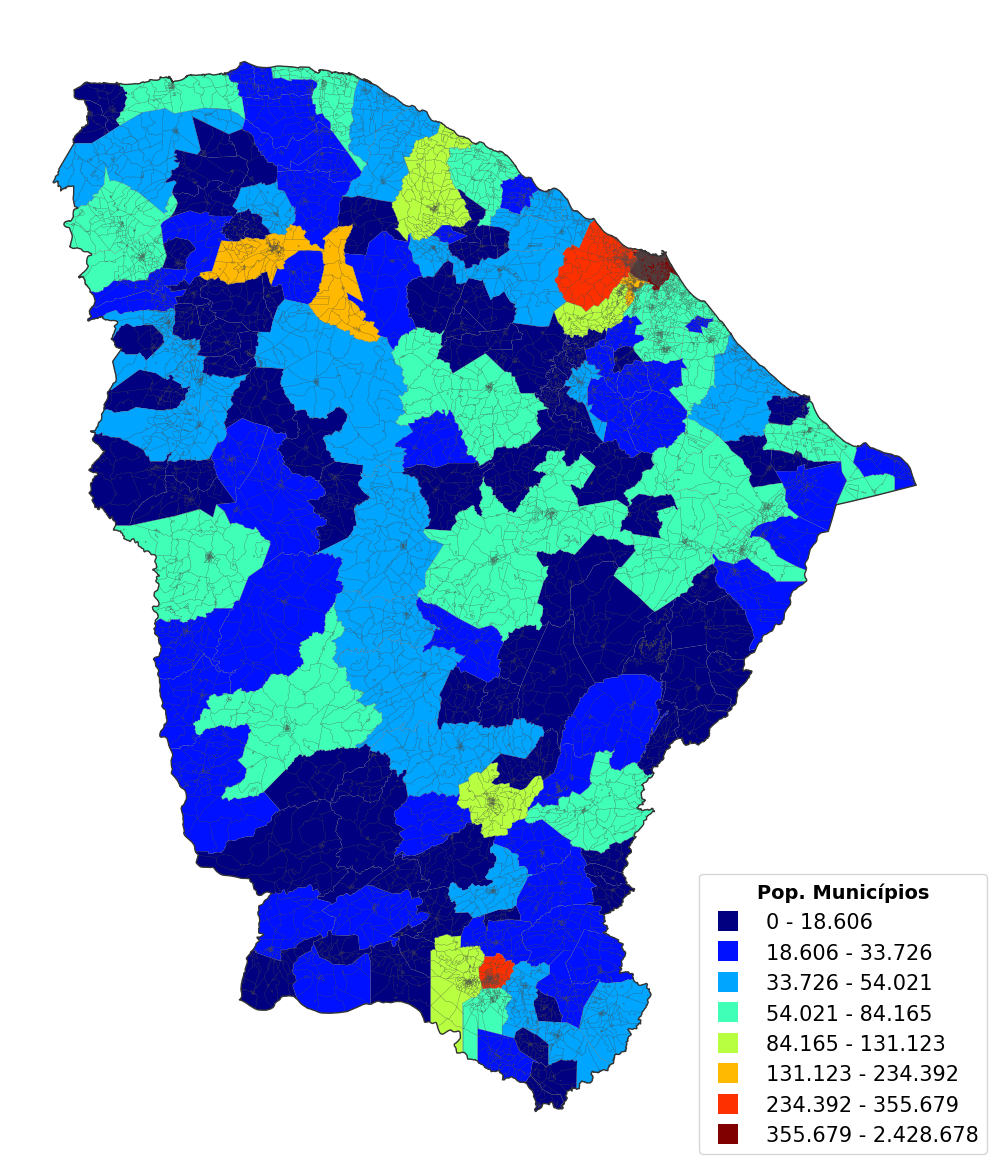

In [26]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.0f} - {label[1]:,.0f}'.replace(",",".")
    else:
        return f'{label[0]:,.0f} - {label[1]:,.0f} ({counts[index]})'.replace(",",".")

fig, ax = plt.subplots(1,1, figsize=(10,14))

ce_geodata_df.plot(ax=ax, column='2022', edgecolor="#4d4d4d", 
              legend=True,
              scheme="NaturalBreaks",
              k=8,
              cmap='jet',
              antialiased=True,
              linewidth=0.0)
setor_df.plot(ax=ax, color='none', edgecolor="#4d4d4d", linewidth=0.1)
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)

for axis in [ax]:
    axis.axis('off')
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(14)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'Pop. Municípios', bbox_to_anchor=(1.04,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

ax.axis('off')
fig.tight_layout()

In [35]:
cca_df = pd.read_parquet(ccapath.joinpath('results',f'clusters_ce_l5_d100.parquet')).reset_index().rename({'index': 'CLUSTER'}, axis=1)

setores_to_info = dict()
clusters = cca_df.CLUSTER.tolist()
for index, codes in enumerate(cca_df.codes.tolist()):
    for code in codes:
        setores_to_info.update({code: clusters[index]})
setor_df["CLUSTER"] = setor_df["CD_SETOR"].map(setores_to_info)
setores1 = setor_df.merge(cca_df[["CLUSTER", "population", "area"]], how="left")

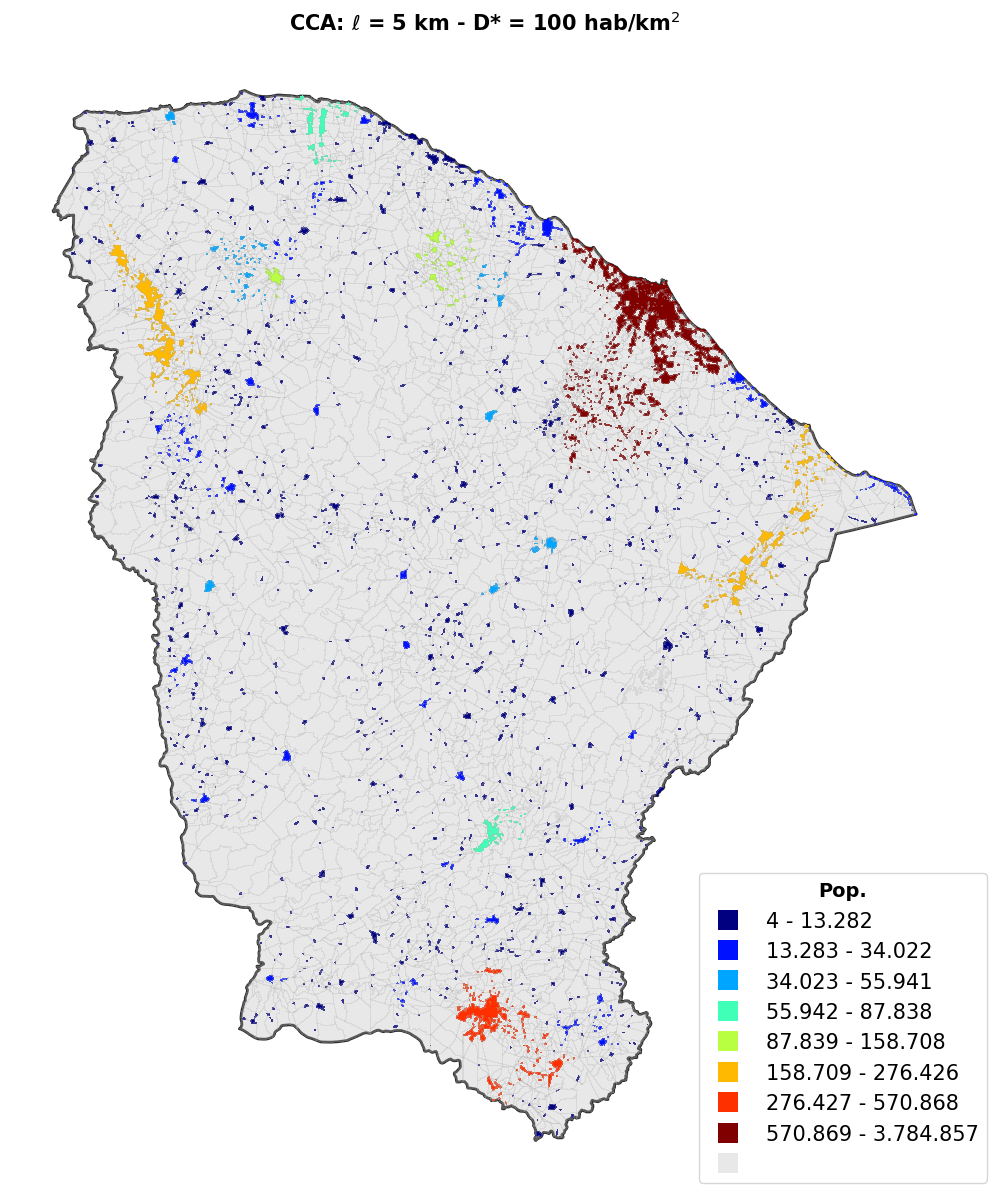

In [99]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, (ax) = plt.subplots(1, figsize=(10,14))

setores1.plot(ax=ax, zorder=2, column=f"population", edgecolor="none", 
             legend=True,
             scheme="NaturalBreaks",
             k=8,
             cmap='jet',
             antialiased=False,
             linewidth=0,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#b3b3b3",
                 "edgecolor": "none",
                 "hatch": "",
                 "label": '',
                 'alpha': 0.3
             })
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=2)

ax.axis('off')

for axis in [ax]:
    axis.axis('off')
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(14)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'Pop.', bbox_to_anchor=(1.04,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
#macro_df.plot(ax=AX1, color="none", edgecolor="#1a1a1a", linewidth=1.4)
#new_macro_geometry.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.4)
ax.set_title(fr'CCA: $\ell$ = 5 km - D* = 100 hab'+fr'/km$^2$', fontsize=15, weight='bold')
fig_mapa.tight_layout()
#fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"cca_pop_l5_D100_original.png"), dpi=250, bbox_inches='tight')

## **Leitos**

In [79]:
valid_cnes_df["CD_SETOR"].unique().shape

(250,)

In [50]:
cca_df = pd.read_parquet(ccapath.joinpath('results',f'clusters_ce_l5_d100.parquet')).reset_index().rename({'index': 'CLUSTER'}, axis=1)
leitos_df = pd.read_parquet(os.path.join(cnespath, "cnes_leitos_timeserie_0801_2312.parquet"))
geodata_df_cca = geodata_df.copy()

setores_to_info = dict()
clusters = cca_df.CLUSTER.tolist()
for index, codes in enumerate(cca_df.codes.tolist()):
    for code in codes:
        setores_to_info.update({code: clusters[index]})
setor_df["CLUSTER"] = setor_df["CD_SETOR"].map(setores_to_info)
#setores1 = setor_df.merge(cca_df[["CLUSTER", "population", "area"]], how="left")

valid_cnes_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cnes_com_aih_1801_2306.parquet"))
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry')

# -- find the census tract of each health unit
setor = setor_df.copy()
cnes_to_sector = dict()
for index in range(valid_cnes_df.shape[0]):
    current_cnes = valid_cnes_df["CNES"].iloc[index]
    current_point = valid_cnes_df.geometry.iloc[index]

    cod_setores = setor[setor.geometry.contains(current_point)]["CD_SETOR"].tolist()
    cnes_to_sector.update({current_cnes: cod_setores[0]})

valid_cnes_df["CD_SETOR"] = valid_cnes_df["CNES"].map(cnes_to_sector)
valid_cnes_df["NUMLEITOS"] = valid_cnes_df["CNES"].apply(lambda x: leitos_df.loc[:, idx[x, "NUMLEITOS_PRINC"]].tolist()[-1])

In [52]:
setor1 = setor[["CD_SETOR", "v0001", "AREA_KM2", "CLUSTER"]].copy()
module_pop = setor.groupby(f"CLUSTER")[["v0001", "AREA_KM2"]].sum().reset_index()
module_pop_dict = dict(zip(module_pop[f"CLUSTER"], module_pop["v0001"]))
module_area_dict = dict(zip(module_pop[f"CLUSTER"], module_pop["AREA_KM2"]))
setor1["CCA_POP"] = setor1[f"CLUSTER"].map(module_pop_dict)
setor1["CCA_AREA"] = setor1[f"CLUSTER"].map(module_area_dict)

valid_cnes_temp = valid_cnes_df.copy()
leitos_per_cluster = valid_cnes_temp.merge(setor1[["CD_SETOR", f"CLUSTER"]]).groupby(f"CLUSTER")["NUMLEITOS"].sum().reset_index()
setor1 = setor1.merge(leitos_per_cluster, on=f"CLUSTER", how="left")
setor1 = setor1[pd.notna(setor1["CLUSTER"])].drop_duplicates(subset=["CLUSTER"])
setor1 = setor1[pd.notna(setor1["NUMLEITOS"])]

In [106]:
temp_ = valid_cnes_df.groupby("CD_SETOR")["NUMLEITOS"].sum().reset_index()
setor_df1 = setor_df.merge(temp_, how='left')
setor_df1 = setor_df1.merge(ce_geodata_df[["MACRO_ID", "REGIAO_SAUDE_8", "GEOCOD7"]], left_on="CD_MUN", right_on="GEOCOD7", how="left")
setor_df1.head(2)

CD_SETOR  AREA_KM2 CD_REGIAO NM_REGIAO CD_UF  NM_UF   CD_MUN  \
0  230010105000001P  0.373958         2  Nordeste    23  Ceará  2300101   
1  230010105000002P  0.076252         2  Nordeste    23  Ceará  2300101   

    NM_MUN    CD_DIST  NM_DIST  ...     v0005 v0006 v0007  \
0  Abaiara  230010105  Abaiara  ...  2.811644   0.0   292   
1  Abaiara  230010105  Abaiara  ...  2.801887   0.0   106   

                                            geometry GEOCOD6 CLUSTER  \
0  POLYGON ((-39.04529 -7.36120, -39.04674 -7.360...  230010     0.0   
1  POLYGON ((-39.05213 -7.36096, -39.05164 -7.361...  230010     0.0   

  NUMLEITOS MACRO_ID REGIAO_SAUDE_8  GEOCOD7  
0       NaN        5              3  2300101  
1       NaN        5              3  2300101  

[2 rows x 36 columns]

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


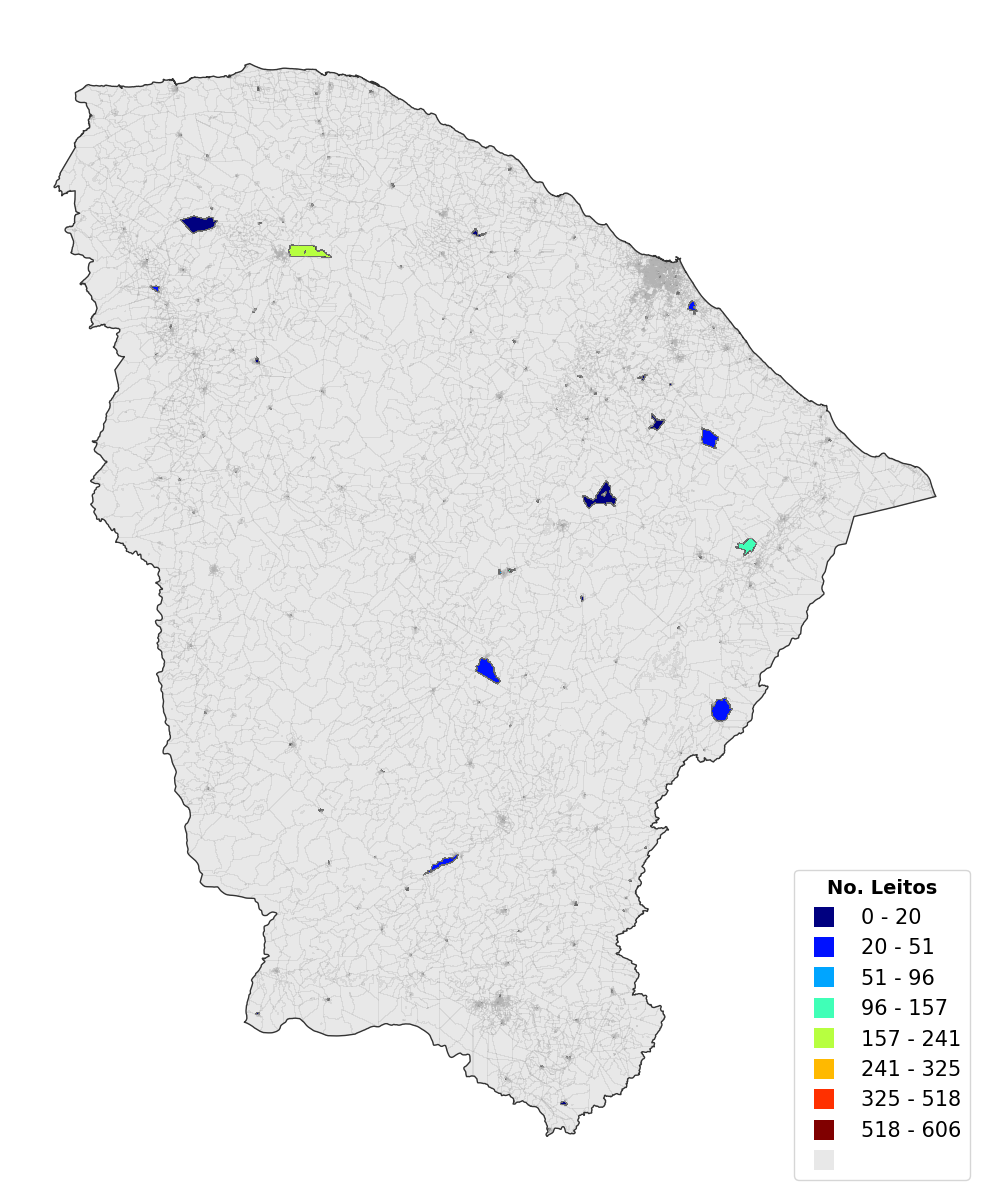

In [126]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.0f} - {label[1]:,.0f}'.replace(",",".")
    else:
        return f'{label[0]:,.0f} - {label[1]:,.0f} ({counts[index]})'.replace(",",".")

fig, ax = plt.subplots(1,1, figsize=(10,14))

setor_df1.plot(ax=ax, column='NUMLEITOS', edgecolor="#4d4d4d", 
              legend=True,
              scheme="NaturalBreaks",
              k=8,
              cmap='jet',
              antialiased=False,
              linewidth=0.2,
              missing_kwds={
                 "color": "#b3b3b3",
                 "edgecolor": "none",
                 "hatch": "",
                 "label": '',
                 'alpha': 0.3
             })
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)

for axis in [ax]:
    axis.axis('off')
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(14)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'No. Leitos', bbox_to_anchor=(1.0,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

ax.axis('off')
fig.tight_layout()

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


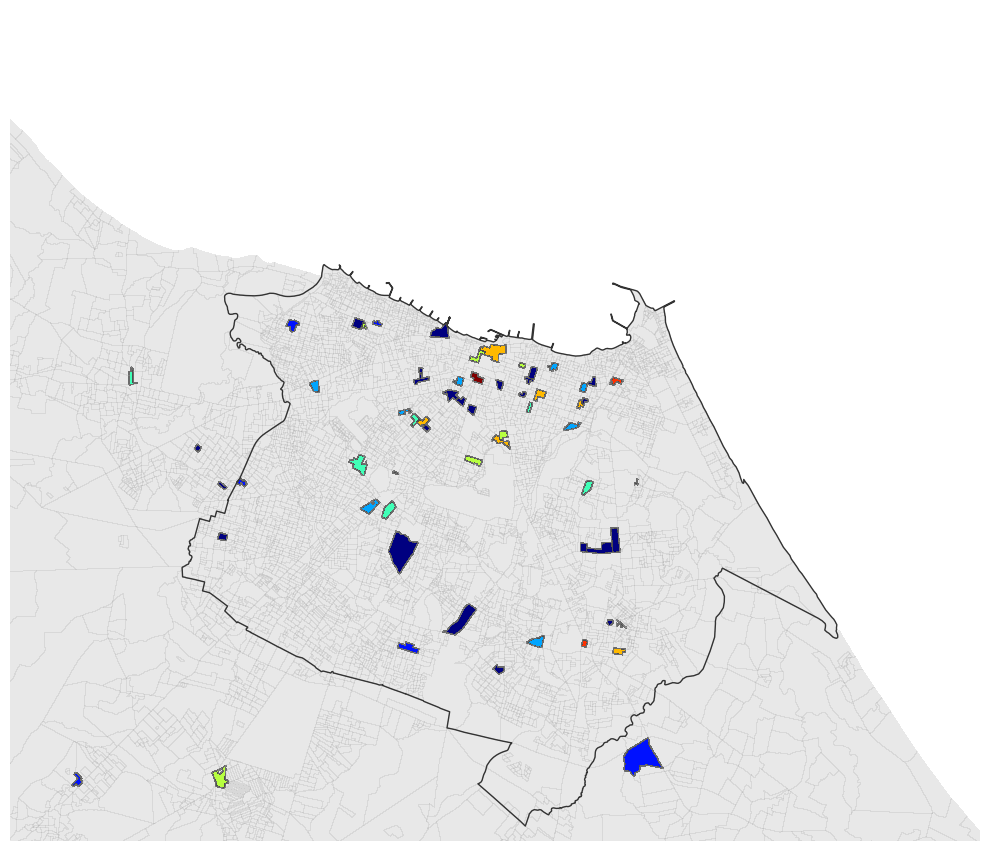

In [124]:
muni_lista = ["Fortaleza", "Caucaia", "Eusébio", "Maracanaú", "Maranguape", "Itaitinga", "Pacatuba", "Aquiraz"]

def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.0f} - {label[1]:,.0f}'.replace(",",".")
    else:
        return f'{label[0]:,.0f} - {label[1]:,.0f} ({counts[index]})'.replace(",",".")

fig, ax = plt.subplots(1,1, figsize=(10,14))
setor_df1[setor_df1["NM_MUN"].isin(muni_lista)].plot(ax=ax, column='NUMLEITOS', edgecolor="#4d4d4d", 
              legend=False,
              scheme="NaturalBreaks",
              k=8,
              cmap='jet',
              antialiased=False,
              linewidth=0.35,
              missing_kwds={
                 "color": "#b3b3b3",
                 "edgecolor": "none",
                 "hatch": "",
                 "label": '',
                 'alpha': 0.3
             })
fortal_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)
#ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)

#for axis in [ax]:
#    #axis.axis('off')
#    leg = axis.get_legend()
#    lines = leg.get_lines()
#    for line in lines:
#        cur_color = line.get_markerfacecolor() 
#        line.set_marker('s')
#        line.set_markersize(14)
#    current_labels = [t.get_text() for t in leg.get_texts()]
#    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
#    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'No', bbox_to_anchor=(1.04,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

#ax.axis('off')
bbox = [-38.7, -3.9, -38.4, -3.6]
ax.axis('off')
ax.set_xlim([-38.7, -38.35])
ax.set_ylim([-3.9, -3.6])

fig.tight_layout()

In [132]:
setor_df2 = setor_df1.copy()
setor_df2["NUMLEITOS"] = setor_df2["NUMLEITOS"].fillna(0)
temp_ = setor_df2.groupby("CD_MUN")["NUMLEITOS"].sum().reset_index()

ce_geodata_df1 = ce_geodata_df.merge(temp_, left_on="GEOCOD7", right_on="CD_MUN", how="left")

c:\Users\Higor Monteiro\anaconda3\envs\mywork\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


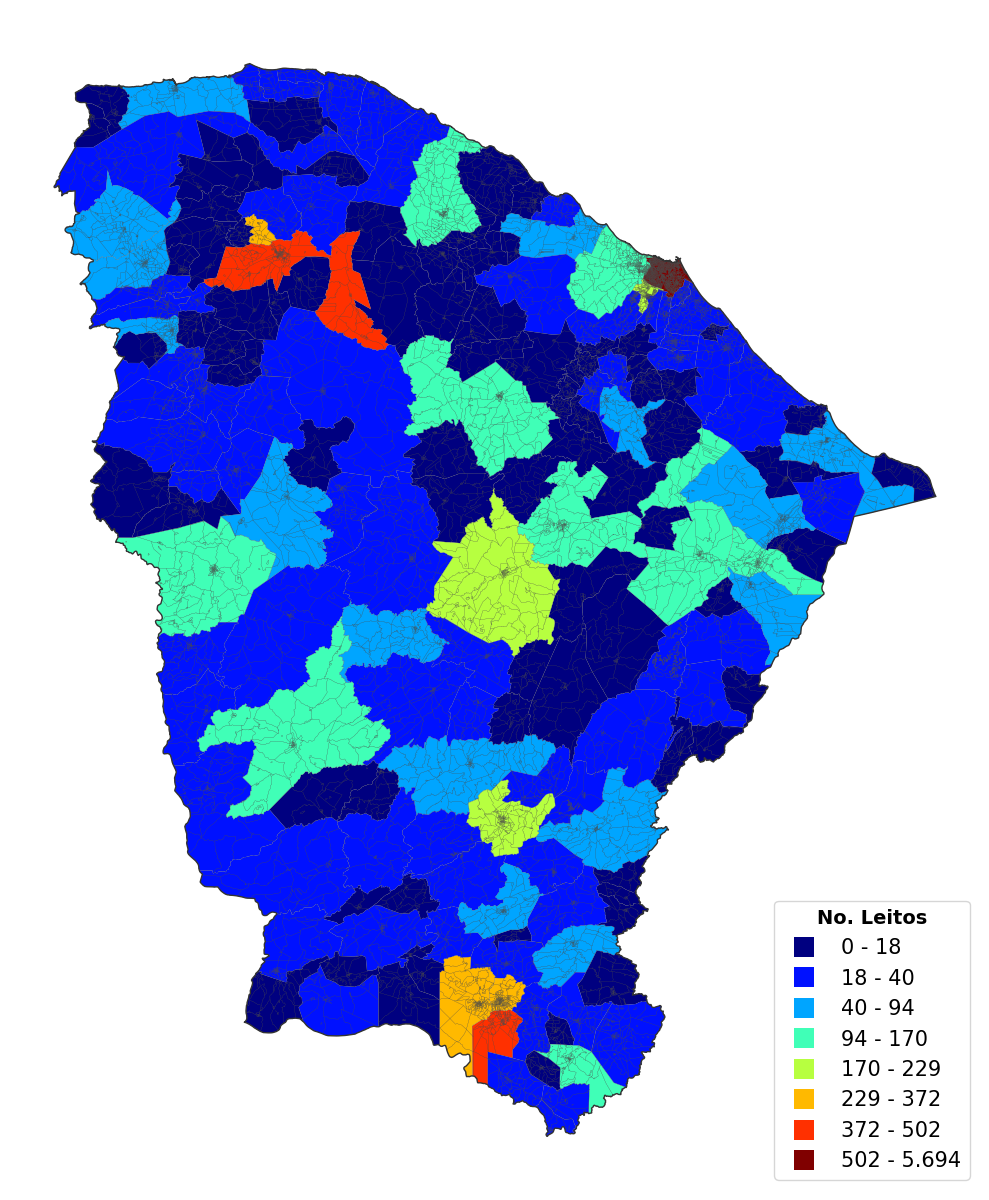

In [133]:
def transf_label(index, label, counts=None):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if label[0]=='-inf' or index==0:
        label[0] = '0'
    if index==0:
        label[0] = float(label[0])
    else:
        label[0] = float(label[0])
    label[1] = float(label[1])
    if counts is None:
        return f'{label[0]:,.0f} - {label[1]:,.0f}'.replace(",",".")
    else:
        return f'{label[0]:,.0f} - {label[1]:,.0f} ({counts[index]})'.replace(",",".")

fig, ax = plt.subplots(1,1, figsize=(10,14))

ce_geodata_df1.plot(ax=ax, column='NUMLEITOS', edgecolor="#4d4d4d", 
              legend=True,
              scheme="NaturalBreaks",
              k=8,
              cmap='jet',
              antialiased=True,
              linewidth=0.0)
setor_df.plot(ax=ax, color='none', edgecolor="#4d4d4d", linewidth=0.1)
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=1)

for axis in [ax]:
    axis.axis('off')
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(14)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'No. Leitos', bbox_to_anchor=(1.0,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

ax.axis('off')
fig.tight_layout()

In [140]:
cca_df = pd.read_parquet(ccapath.joinpath('results',f'clusters_ce_l5_d100.parquet')).reset_index().rename({'index': 'CLUSTER'}, axis=1)
leitos_df = pd.read_parquet(os.path.join(cnespath, "cnes_leitos_timeserie_0801_2312.parquet"))
geodata_df_cca = geodata_df.copy()

setores_to_info = dict()
clusters = cca_df.CLUSTER.tolist()
for index, codes in enumerate(cca_df.codes.tolist()):
    for code in codes:
        setores_to_info.update({code: clusters[index]})
setor_df["CLUSTER"] = setor_df["CD_SETOR"].map(setores_to_info)
#setores1 = setor_df.merge(cca_df[["CLUSTER", "population", "area"]], how="left")

valid_cnes_df = pd.read_parquet(os.path.join(gmlpath, "dados_for_plot", "cnes_com_aih_1801_2306.parquet"))
valid_cnes_df["geometry"] = gpd.points_from_xy(valid_cnes_df.longitude, valid_cnes_df.latitude)
valid_cnes_df = gpd.GeoDataFrame(valid_cnes_df, geometry='geometry')

# -- find the census tract of each health unit
setor = setor_df.copy()
cnes_to_sector = dict()
for index in range(valid_cnes_df.shape[0]):
    current_cnes = valid_cnes_df["CNES"].iloc[index]
    current_polygon = valid_cnes_df.geometry.iloc[index]

    cod_setores = setor[setor.geometry.contains(current_polygon)]["CD_SETOR"].tolist()
    cnes_to_sector.update({current_cnes: cod_setores[0]})

valid_cnes_df["CD_SETOR"] = valid_cnes_df["CNES"].map(cnes_to_sector)
valid_cnes_df["NUMLEITOS"] = valid_cnes_df["CNES"].apply(lambda x: leitos_df.loc[:, idx[x, "NUMLEITOS_PRINC"]].tolist()[-1])

In [142]:
setor1 = setor[["CD_SETOR", "v0001", "AREA_KM2", "CLUSTER"]].copy()
module_pop = setor.groupby(f"CLUSTER")[["v0001", "AREA_KM2"]].sum().reset_index()
module_pop_dict = dict(zip(module_pop[f"CLUSTER"], module_pop["v0001"]))
module_area_dict = dict(zip(module_pop[f"CLUSTER"], module_pop["AREA_KM2"]))
setor1["CCA_POP"] = setor1[f"CLUSTER"].map(module_pop_dict)
setor1["CCA_AREA"] = setor1[f"CLUSTER"].map(module_area_dict)

valid_cnes_temp = valid_cnes_df.copy()
leitos_per_cluster = valid_cnes_temp.merge(setor1[["CD_SETOR", f"CLUSTER"]]).groupby(f"CLUSTER")["NUMLEITOS"].sum().reset_index()
setor1 = setor1.merge(leitos_per_cluster, on=f"CLUSTER", how="left")
setor1 = setor1[pd.notna(setor1["CLUSTER"])].drop_duplicates(subset=["CLUSTER"])
setor1 = setor1[pd.notna(setor1["NUMLEITOS"])]

setor_leitos_df = setor_df.merge(setor1[["CLUSTER", "NUMLEITOS"]], how="left")[["CD_SETOR", "NUMLEITOS", "geometry"]]

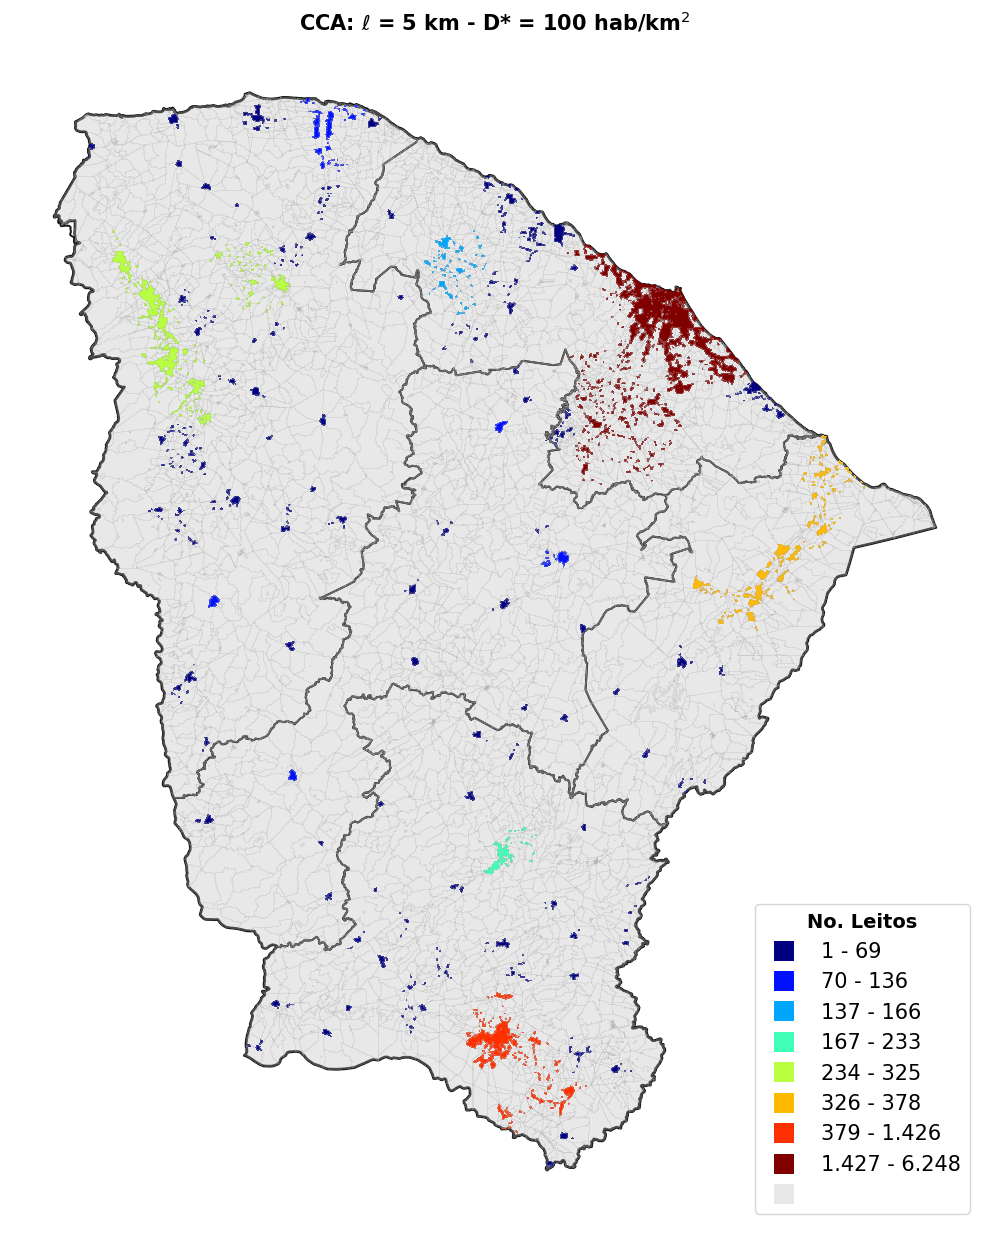

In [146]:
def transf_label(index, label):
    label = label.replace("[", "").replace("]", "").replace("(", "")
    label = [ n.strip() for n in label.split(",") ]
    if len(label)==1:
        return label[0]
    if index==0:
        label[0] = int(label[0])
    else:
        label[0] = int(label[0])+1
    label[1] = int(label[1])
    return f'{label[0]:,} - {label[1]:,}'.replace(",",".")

# -- geometry ceará
fig_mapa, (ax) = plt.subplots(1, figsize=(10,14))

setor_leitos_df.plot(ax=ax, zorder=2, column=f"NUMLEITOS", edgecolor="none", 
             legend=True,
             scheme="NaturalBreaks",
             k=8,
             cmap='jet',
             antialiased=False,
             linewidth=0,
             legend_kwds={
                 'loc': 4,
                 'prop': {'size':18},
                 'markerscale': 1.6,
                 "fmt": "{:.0f}",
                 "interval": True
             },
             missing_kwds={
                 "color": "#b3b3b3",
                 "edgecolor": "none",
                 "hatch": "",
                 "label": '',
                 'alpha': 0.3
             })
ce_border.plot(ax=ax, color='none', edgecolor="#333333", linewidth=2)

ax.axis('off')

for axis in [ax]:
    axis.axis('off')
    leg = axis.get_legend()
    lines = leg.get_lines()
    for line in lines:
        cur_color = line.get_markerfacecolor() 
        line.set_marker('s')
        line.set_markersize(14)
    current_labels = [t.get_text() for t in leg.get_texts()]
    new_labels =  [ transf_label(index, label) for index, label in enumerate(current_labels) ]
    axis.legend(lines, new_labels, prop={'size': 15}, loc=4, title=f'No. Leitos', bbox_to_anchor=(1.0,0.0), title_fontproperties={'weight': 'bold', 'size': 14})

macro_df = geodata_df.drop_duplicates("MACRO_ID", keep='first')[["MACRO_ID", "MACRO_COLOR", "MACRO_NOME", "geometry_macro"]]
macro_df = macro_df.set_geometry("geometry_macro")
macro_df.plot(ax=ax, color="none", edgecolor="#1a1a1a", linewidth=1.4)
#new_macro_geometry.plot(ax=AX1, color="none", zorder=3, edgecolor="#1a1a1a", linewidth=1.4)
ax.set_title(fr'CCA: $\ell$ = 5 km - D* = 100 hab'+fr'/km$^2$', fontsize=15, weight='bold')
fig_mapa.tight_layout()
#fig_mapa.savefig(basepath.joinpath("redes_aih", "doc_final", f"cca_pop_l5_D100_original.png"), dpi=250, bbox_inches='tight')